In [15]:
import pandas as pd
import numpy as np
#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('wordnet')
#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
#for word embedding
from gensim.models.word2vec import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument 

In [16]:
from sklearn.datasets import fetch_20newsgroups
import pandas as pd

def twenty_newsgroup_to_csv():
    newsgroups_train = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))

    df = pd.DataFrame([newsgroups_train.data, newsgroups_train.target.tolist()]).T
    df.columns = ['text', 'target']

    targets = pd.DataFrame( newsgroups_train.target_names)
    targets.columns=['title']

    out = pd.merge(df, targets, left_on='target', right_index=True)
    out['date'] = pd.to_datetime('now')
    out.to_csv('20_newsgroup.csv')
    
twenty_newsgroup_to_csv()

In [17]:
data = pd.read_csv('20_newsgroup.csv', index_col = 0)
# Select only 5 classes
class_mask = data["target"].isin([7,9,13,18,19])
data = data[class_mask]
data.head()

,text,target,title,date
9,\nIf a Christian means someone who believes in...,19,talk.religion.misc,2022-04-05 17:35:19.576242
10,the blood of the lamb.\n\nThis will be a hard ...,19,talk.religion.misc,2022-04-05 17:35:19.576242
12,930418\n\nDo what thou wilt shall be the whole...,19,talk.religion.misc,2022-04-05 17:35:19.576242
40,\n\nNo. Zeno's paradox is resolved by showing...,19,talk.religion.misc,2022-04-05 17:35:19.576242
58,"\nDefinitely, J.R. ""Bob"" Dobbs, numero uno, to...",19,talk.religion.misc,2022-04-05 17:35:19.576242


In [18]:
#SPLITTING THE TRAINING DATASET INTO TRAIN AND TEST
df_train, df_test = train_test_split(data,test_size=0.2,shuffle=True)

In [19]:
! pip install seaborn

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

rec.sport.baseball    789
sci.med               785
rec.autos             784
talk.politics.misc    626
talk.religion.misc    517
Name: title, dtype: int64


C:\Users\javij\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0.5, 1.0, 'Number of douments in each class')]

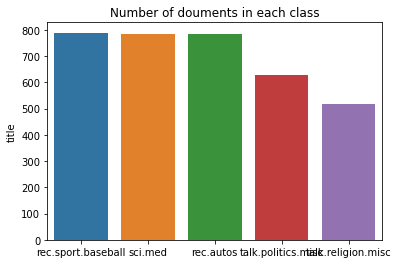

In [21]:
x=df_train['title'].value_counts()
print(x)
sns.barplot(x.index,x).set(title="Number of douments in each class")

In [22]:
# Find NaN values
df_train.isna().sum()

text      97
target     0
title      0
date       0
dtype: int64

In [23]:
# WORD-COUNT
df_train['word_count'] = df_train['text'].apply(lambda x: len(str(x).split()))
print(df_train[df_train['target']==7]['word_count'].mean()) # Cars posts
print(df_train[df_train['target']==9]['word_count'].mean()) # Baseball posts

117.34693877551021
127.49683143219265


In [24]:
df_train = df_train.dropna()

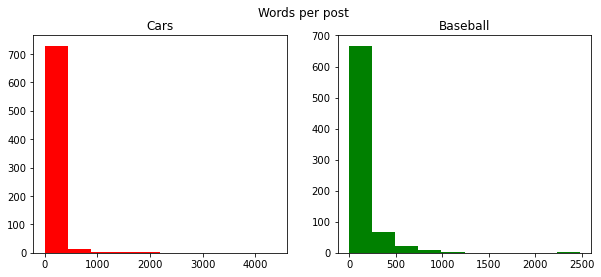

In [25]:
# PLOTTING WORD-COUNT
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
train_words=df_train[df_train['target']==7]['word_count']
ax1.hist(train_words,color='red')
ax1.set_title('Cars')
train_words=df_train[df_train['target']==9]['word_count']
ax2.hist(train_words,color='green')
ax2.set_title('Baseball')
fig.suptitle('Words per post')
plt.show()

In [26]:
# CHARACTER-COUNT
df_train['char_count'] = df_train['text'].apply(lambda x: len(str(x)))
print(df_train[df_train['target']==7]['char_count'].mean()) # Cars
print(df_train[df_train['target']==9]['char_count'].mean()) # Baseball

710.584
761.6142857142858


In [27]:
#convert to lowercase, strip and remove punctuations
def preprocess(text):
    text = text.lower() 
    text=text.strip()  
    text=re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    return text

 
# STOPWORD REMOVAL
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)
#LEMMATIZATION
# Initialize the lemmatizer
wl = WordNetLemmatizer()
 
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

In [28]:
def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))
df_train['clean_text'] = df_train['text'].apply(lambda x: finalpreprocess(x))
df_train.head()

,text,target,title,date,word_count,char_count,clean_text
14439,"\n\nNaw, the owners of WordPerfect are Mormon...",19,talk.religion.misc,2022-04-05 17:35:19.576242,19,126,naw owner wordperfect mormon tony rise robert ...
11376,: The median of a distribution is that variate...,18,talk.politics.misc,2022-04-05 17:35:19.576242,199,1113,median distribution variate value divide distr...
7724,: \n: >It's quite possible that a buyer and se...,18,talk.politics.misc,2022-04-05 17:35:19.576242,217,1185,quite possible buyer seller trust third party ...
11593,I am just wondering whether the official MLB s...,9,rec.sport.baseball,2022-04-05 17:35:19.576242,18,105,wonder whether official mlb stats include inte...
14102,\nIn the kind I have made I used a Lite sour c...,13,sci.med,2022-04-05 17:35:19.576242,46,218,kind make use lite sour cream instead yogurt m...


In [29]:
#SPLITTING THE TRAINING DATASET INTO TRAIN AND TEST
X_train, X_test, y_train, y_test = train_test_split(df_train["clean_text"],df_train["target"],test_size=0.2,shuffle=True)
#Word2Vec
# Word2Vec runs on tokenized sentences
X_train_tok= [nltk.word_tokenize(i) for i in X_train]  
X_test_tok= [nltk.word_tokenize(i) for i in X_test]

In [30]:
#Tf-Idf vectorizer
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) 
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test)

In [43]:
train_docs = [TaggedDocument(doc.split(' '), [i]) 
             for i, doc in enumerate(df_train.clean_text)]

#df_train['clean_text_tok']=[nltk.word_tokenize(i) for i in df_train['clean_text']]
#model = Doc2Vec(df_train['clean_text_tok'],min_count=1) 
#model.train(df_train['clean_text_tok'],total_examples=model.corpus_count,epochs=model.epochs) 
#vocabulary = model.wv.key_to_index
#print(vocabulary)
#X_train_vectors_w2v = model.infer_vector(X_train)


#build the model
model = Doc2Vec(vector_size=64, window=2, min_count=1, workers=8, epochs = 40)
#build vocab
model.build_vocab(train_docs)
#train model
model.train(train_docs, total_examples=model.corpus_count, epochs=model.epochs)

#w2v = dict(zip(model.wv.index_to_key, model.wv.syn0)) 
#modelw = MeanEmbeddingVectorizer(w2v)
# converting text to numerical data using Word2Vec
#X_train_vectors_w2v = modelw.transform(X_train_tok)
#X_val_vectors_w2v = modelw.transform(X_test_tok)

In [46]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words)) for doc in sents])
    return targets, regressors

In [49]:
# Obtain vectors via doc2vec
y_train_w2v, x_train_w2v = vec_for_learning(model, train_docs)


In [52]:
x_train_w2v

(array([ 0.771427  , -1.0745671 , -0.13265891, -0.28214818, -0.43058816,
         0.37997416,  0.31552976, -0.30225006, -0.58405507, -0.304975  ,
         0.16333805,  0.16455548,  0.23860429,  0.179273  , -0.04441547,
         0.10227469, -0.50709075, -0.24999082, -0.37373817, -0.18012153,
         0.14622667,  0.11371728,  0.18054613, -0.901034  , -0.12711966,
        -0.10272559,  0.21278271,  0.18111412, -0.23633496, -0.05039059,
        -0.33828714, -0.21039239, -0.63614213,  0.08580329, -0.44836488,
         0.19715093, -0.32095236,  0.5034694 , -0.15976974,  0.3309217 ,
         0.26684362, -0.4450727 ,  0.3340887 , -0.22414525, -0.07863731,
        -0.6301847 , -0.026002  ,  0.3834084 ,  0.06324108,  0.04907064,
         0.04831195, -0.4913227 , -0.4957226 , -0.52551585, -0.17102776,
         0.4492464 , -0.14427851, -0.02625761, -0.8249938 ,  0.44772425,
        -0.35358024,  0.37508595,  0.35817707, -0.13595024], dtype=float32),
 array([ 4.3149707e-01, -1.4575070e+00, -1.3995

In [34]:
#FITTING THE CLASSIFICATION MODEL using Logistic Regression(tf-idf)
lr_tfidf=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_tfidf.fit(X_train_vectors_tfidf, y_train)  
#Predict y value for test dataset
y_predict = lr_tfidf.predict(X_test_vectors_tfidf)
y_prob = lr_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]
print(classification_report(y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, balanced_accuracy_score

svm_acc = accuracy_score(y_test, y_predict)
svm_f1 = f1_score(y_test, y_predict, average ='weighted')
svm_bacc = balanced_accuracy_score(y_test, y_predict)

print(f"Test Accuracy of Logistic Regression(tf-idf) is {svm_acc} \n")
print(f"Test Balanced Accuracy of Logistic Regression(tf-idf) is {svm_bacc} \n")
print(f"Test F1-score weighted of Logistic Regression(tf-idf) is {svm_f1} \n")

              precision    recall  f1-score   support

           7       0.82      0.92      0.87       136
           9       0.91      0.95      0.93       164
          13       0.91      0.88      0.90       147
          18       0.83      0.87      0.84       126
          19       0.98      0.74      0.84       108

    accuracy                           0.88       681
   macro avg       0.89      0.87      0.87       681
weighted avg       0.89      0.88      0.88       681

Confusion Matrix: [[125   3   2   6   0]
 [  4 155   4   1   0]
 [ 12   1 130   4   0]
 [  6   7   2 109   2]
 [  6   5   5  12  80]]
Test Accuracy of Logistic Regression(tf-idf) is 0.8795888399412628 

Test Balanced Accuracy of Logistic Regression(tf-idf) is 0.870882689119008 

Test F1-score weighted of Logistic Regression(tf-idf) is 0.8790217929541533 



In [35]:
#FITTING THE CLASSIFICATION MODEL using Naive Bayes(tf-idf)
nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_vectors_tfidf, y_train)  
#Predict y value for test dataset
y_predict = nb_tfidf.predict(X_test_vectors_tfidf)
y_prob = nb_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]
print(classification_report(y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))

svm_acc = accuracy_score(y_test, y_predict)
svm_f1 = f1_score(y_test, y_predict, average ='weighted')
svm_bacc = balanced_accuracy_score(y_test, y_predict)

print(f"Test Accuracy of Naive Bayes(tf-idf) is {svm_acc} \n")
print(f"Test Balanced Accuracy of Naive Bayes(tf-idf) is {svm_bacc} \n")
print(f"Test F1-score weighted of Naive Bayes(tf-idf) is {svm_f1} \n")

              precision    recall  f1-score   support

           7       0.86      0.93      0.89       136
           9       0.90      0.96      0.93       164
          13       0.77      0.93      0.85       147
          18       0.81      0.83      0.82       126
          19       0.98      0.48      0.65       108

    accuracy                           0.85       681
   macro avg       0.86      0.83      0.83       681
weighted avg       0.86      0.85      0.84       681

Confusion Matrix: [[126   2   5   3   0]
 [  1 157   6   0   0]
 [  6   2 137   2   0]
 [  5   6   9 105   1]
 [  9   7  20  20  52]]
Test Accuracy of Naive Bayes(tf-idf) is 0.8472834067547724 

Test Balanced Accuracy of Naive Bayes(tf-idf) is 0.8261150530672975 

Test F1-score weighted of Naive Bayes(tf-idf) is 0.8383196300354278 

